In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploratory analysis 

In [ ]:
!pip install squarify

In [ ]:
# Importing the relevant libraries
import IPython.display
import json
import pandas as pd
import seaborn as sns
import squarify
%matplotlib inline
import missingno as msno
import plotly.offline as py
py.init_notebook_mode()
import plotly.graph_objs as go
import plotly.tools as tls
import numpy as np
from matplotlib import pyplot as plt
color = sns.color_palette()

# D3 modules
from IPython.core.display import display, HTML, Javascript
from string import Template

Output hidden; open in https://colab.research.google.com to view.

## Explore and prepare the data

In [ ]:
data_folder = "drive/My Drive/favorita/data/"

items = pd.read_csv(f"{data_folder}/items.csv")
holiday_events = pd.read_csv(f"{data_folder}/holidays_events.csv", parse_dates=['date'])
stores = pd.read_csv(f"{data_folder}/stores.csv")
oil = pd.read_csv(f"{data_folder}/oil.csv", parse_dates=['date'])
transactions = pd.read_csv(f"{data_folder}/transactions.csv", parse_dates=['date'])

# the full training data's output: "125,497,040 rows | 6 columns"
#Therefore I will only load approx 5% of the data just to get a rough idea of what is in store for us.
train = pd.read_csv(f"{data_folder}/train.csv", nrows=6000000  , parse_dates=['date'])
train_large = pd.read_csv(f"{data_folder}/train.csv", skiprows = 66458909, names = train.columns, parse_dates = ['date'])


In [ ]:
weather = pd.read_csv(f"{data_folder}/weather.csv", parse_dates=['Date'])

In [ ]:
def check_missing(dataset):

  print('Null/Missing values\n', dataset.isnull().sum())

  # making a bool series of duplicated items
  bool_series = dataset.duplicated(keep = False)
  print('Duplicated rows:', dataset[bool_series].shape[0])

In [ ]:
check_missing(items)
print("="*70)
check_missing(holiday_events)
print("="*70)
check_missing(stores)
print("="*70)
check_missing(oil)
print("="*70)
check_missing(transactions)
print("="*70)
check_missing(weather)

Null/Missing values
 item_nbr      0
family        0
class         0
perishable    0
dtype: int64
Duplicated rows: 0
Null/Missing values
 date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
Duplicated rows: 0
Null/Missing values
 store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
Duplicated rows: 0
Null/Missing values
 date           0
dcoilwtico    43
dtype: int64
Duplicated rows: 0
Null/Missing values
 date            0
store_nbr       0
transactions    0
dtype: int64
Duplicated rows: 0
Null/Missing values
 Date        0
MaxTemp     0
AvgTemp     0
location    0
dtype: int64
Duplicated rows: 2420


In [ ]:
print("oil start and end date:",oil.date.min(), oil.date.max())

oil start and end date: 2013-01-01 00:00:00 2017-08-31 00:00:00


In [ ]:
# Check missing dates
missing_dates = set(pd.date_range(start=oil.date.min(), end=oil.date.max())) - set(oil.date)
print('Missing dates count:', len(missing_dates))

Missing dates count: 486


In [ ]:
print("weather start and end date:",weather.Date.min(), weather.Date.max())

weather start and end date: 2013-01-01 00:00:00 2017-09-01 00:00:00


In [ ]:
# Check missing dates
missing_dates = set(pd.date_range(start=weather.Date.min(), end=weather.Date.max())) - set(weather.Date)
print('Missing dates count:', len(missing_dates))

Missing dates count: 0


 The only missing data occurs in the oil data file, which provides the historical daily price for oil.

In [ ]:
#forward and backword fill to imput oil prices
oil['dcoilwtico_imputed'] = oil['dcoilwtico'].ffill(axis = 0) 
oil['dcoilwtico_imputed'] = oil['dcoilwtico'].bfill(axis = 0) 


In [ ]:
# dropping ALL duplicte values 
weather.drop_duplicates(keep = 'first', inplace = True)

## External data

In [ ]:
oil.head(3)

In [ ]:
trace = go.Scatter(
     name='Oil prices',
     x=oil['date'],
     y=oil['dcoilwtico'].dropna(),
     mode='lines',
     line=dict(color='rgb(200, 15, 20, 0.8)'),
     #fillcolor='rgba(68, 68, 68, 0.3)',
     fillcolor='rgba(200, 15, 20, 0.3)',
     fill='tonexty' )

data = [trace]

layout = go.Layout(
     yaxis=dict(title='Daily Oil price'),
     title='Daily oil prices from Jan 2013 till July 2017',
     showlegend = False)
fig = go.Figure(data=data, layout=layout)
#  py.iplot(fig, filename='pandas-time-series-error-bars')
fig.show(renderer="colab")

In [ ]:

train_date = train_large[(train_large["date"]>=pd.datetime(2017,1,1))].groupby("date")["unit_sales"].sum()

train_oil = pd.merge(train_date,oil,left_on ="date",right_on ="date")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [ ]:
train_oil[['dcoilwtico','unit_sales']].corr()

,dcoilwtico,unit_sales
dcoilwtico,1.000000,0.079401
unit_sales,0.079401,1.000000


In [ ]:
train_oil['unit_sales'] = np.log1p(train_oil['unit_sales'])
train_oil['unit_sales'] = train_oil['unit_sales'] / train_oil['unit_sales'].max()
train_oil['dcoilwtico'] = train_oil['dcoilwtico'] / train_oil['dcoilwtico'].max()

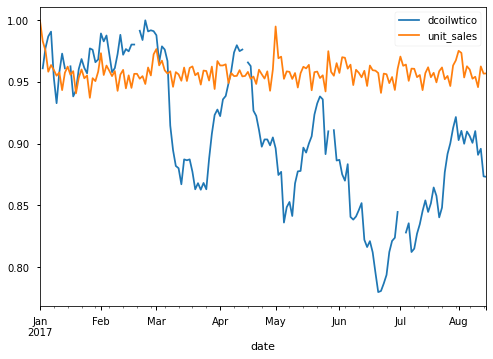

In [ ]:
train_oil.set_index("date")[['dcoilwtico','unit_sales']].plot()

In [ ]:
weather.set_index("Date",inplace=True)

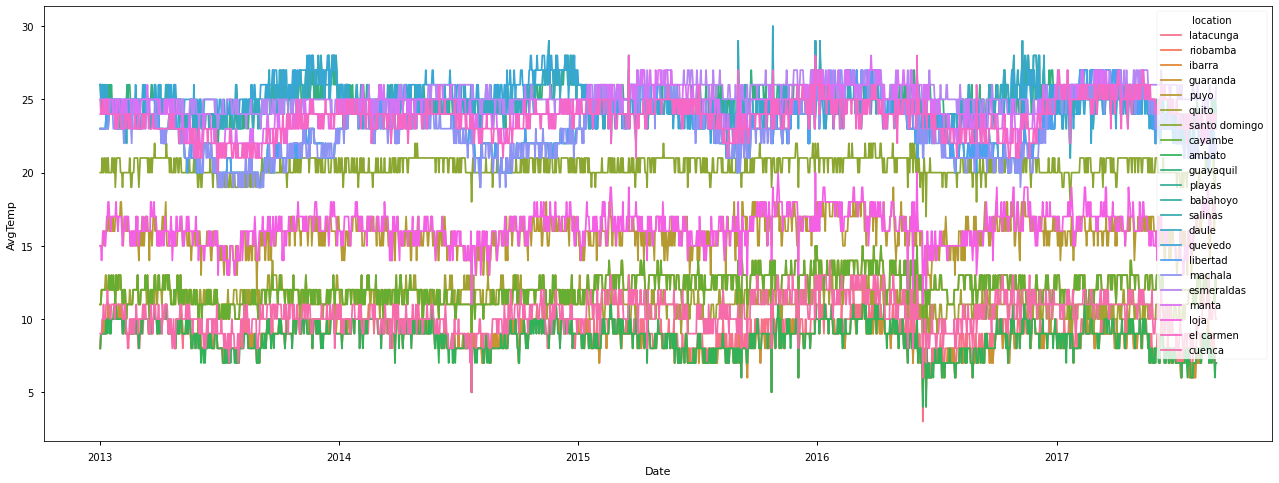

In [ ]:
plt.style.use('seaborn-notebook')
plt.figure(figsize=(22, 8))
sns.lineplot(x="Date", y="AvgTemp", hue="location", data=weather[['Date','MaxTemp', 'AvgTemp', 'location']], color=sns.color_palette("Paired"))

In [ ]:
stores["city"].unique()

array(['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
       'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
       'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
       'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [ ]:
selected_city = "Quito"

#@title city for weather analysis:
selected_city = "Manta"  #@param ['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba','Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas','Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca','Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen']
quito_stores = stores[stores["city"] == selected_city]["store_nbr"].values
quito_stores

array([52, 53])

In [ ]:
quito_unit_sales = train_large[(train_large["date"]>=pd.datetime(2017,1,1)) & (train_large["store_nbr"].isin(quito_stores))].groupby("date")["unit_sales"].sum().reset_index().set_index("date")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [ ]:
weather_quito = weather[weather["location"]==selected_city.lower()][["MaxTemp","AvgTemp","Date"]]

In [ ]:
single_location_unit_sales_weather = pd.merge(quito_unit_sales,weather_quito,left_on ="date",right_on ="Date")

In [ ]:
single_location_unit_sales_weather[['AvgTemp','unit_sales']].corr()

,AvgTemp,unit_sales
AvgTemp,1.000000,-0.565875
unit_sales,-0.565875,1.000000


In [ ]:

single_location_unit_sales_weather['unit_sales'] = np.log1p(single_location_unit_sales_weather['unit_sales'])
single_location_unit_sales_weather['unit_sales'] = single_location_unit_sales_weather['unit_sales'] / single_location_unit_sales_weather['unit_sales'].max()
single_location_unit_sales_weather['AvgTemp'] = single_location_unit_sales_weather['AvgTemp'] / single_location_unit_sales_weather['AvgTemp'].max()

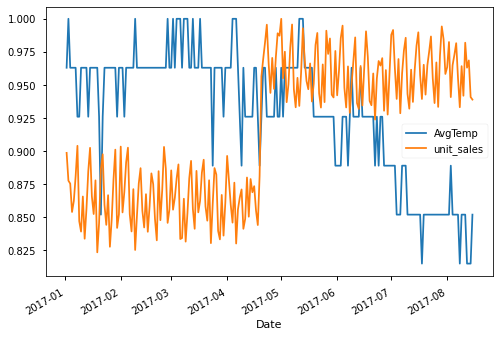

In [ ]:
single_location_unit_sales_weather.set_index("Date")[['AvgTemp','unit_sales']].plot()

## Stores Data

In [ ]:
stores.head(3)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



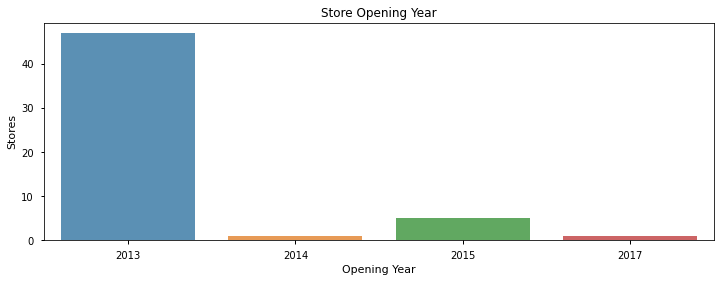

In [ ]:
temp=transactions.groupby(['store_nbr']).agg({'date':[np.min,np.max]}).reset_index()
temp['store_age']=temp['date']['amax']-temp['date']['amin']
temp['open_year']=temp['date']['amin'].dt.year
data=temp['open_year'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(data.index,data.values, alpha=0.8)
plt.ylabel('Stores')
plt.xlabel('Opening Year')
plt.title('Store Opening Year')
plt.show()

5 Stores were opened in 2015 and 1 each in 2014 and 2017

In [ ]:
stores

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


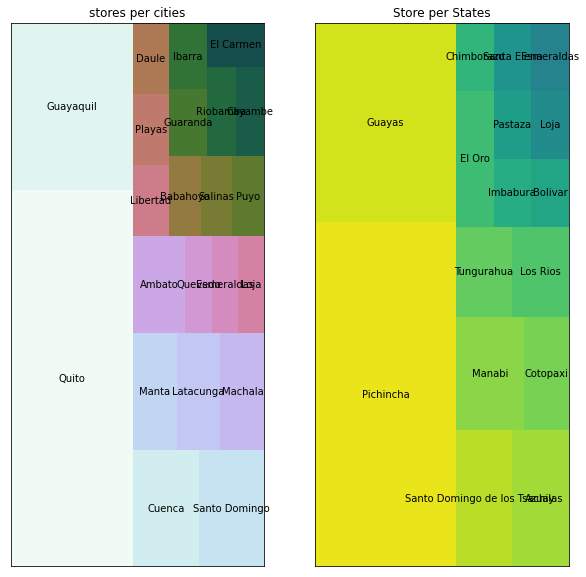

In [ ]:
#fig = plt.figure(figsize=(20, 20))
df_city_count=stores.city.value_counts().to_frame()
#ax = fig.add_subplot((2,1), aspect="equal")
fig,axs = plt.subplots(1,2,figsize=(10, 10))
ax = squarify.plot(ax=axs[0],sizes=df_city_count['city'].values,label=df_city_count.index,
              color=sns.color_palette('cubehelix_r', 28), alpha=1)
ax.set_xticks([])
ax.set_yticks([])
# fig=plt.gcf()
#fig.set_size_inches(40,25)
ax.set_title("stores per cities")
# plt.show();


#fig = plt.figure(figsize=(25, 21))
df_city_count=stores.state.value_counts().to_frame()
#ax = fig.add_subplot(111, aspect="equal")
ax = squarify.plot(ax=axs[1], sizes=df_city_count['state'].values,label=df_city_count.index,
              color=sns.color_palette('viridis_r', 28), alpha=1)
ax.set_xticks([])
ax.set_yticks([])
# fig=plt.gcf()
ax.set_title("Store per States")
plt.show()

In [ ]:
stores.state.unique()

array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

Text(0.5, 1.0, 'Store numbers and the clusters they are assigned to')

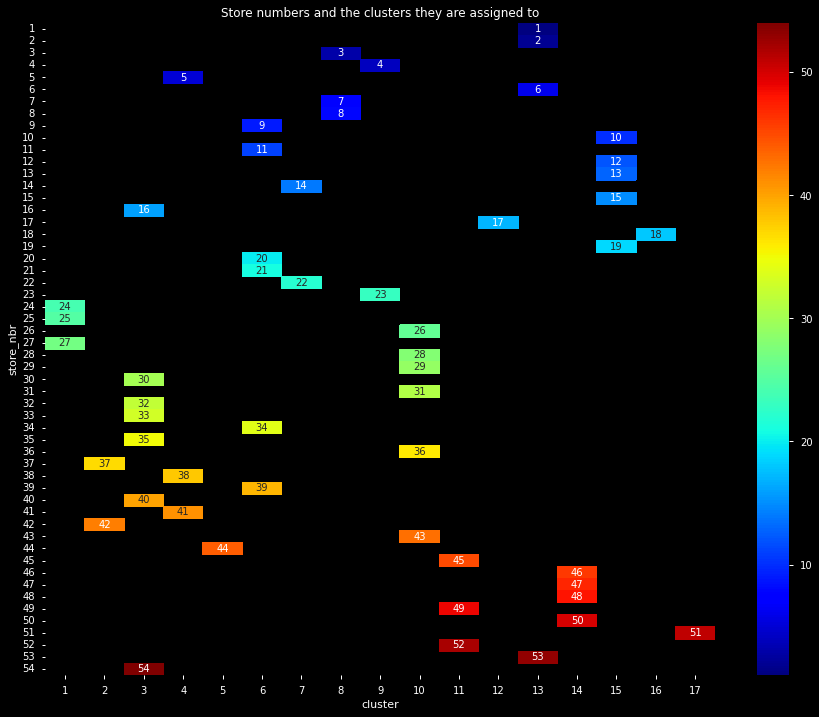

In [ ]:
# Finally plot the seaborn heatmap
plt.style.use('dark_background')
plt.figure(figsize=(15,12))
store_pivot = stores.dropna().pivot("store_nbr","cluster", "store_nbr")
ax = sns.heatmap(store_pivot, cmap='jet', annot=True, linewidths=0, linecolor='white')
plt.title('Store numbers and the clusters they are assigned to')

we can look at the distribution of clusters based on the store type to see if we can identify any apparent relationship between types and the way the company has decided to cluster the particular store.

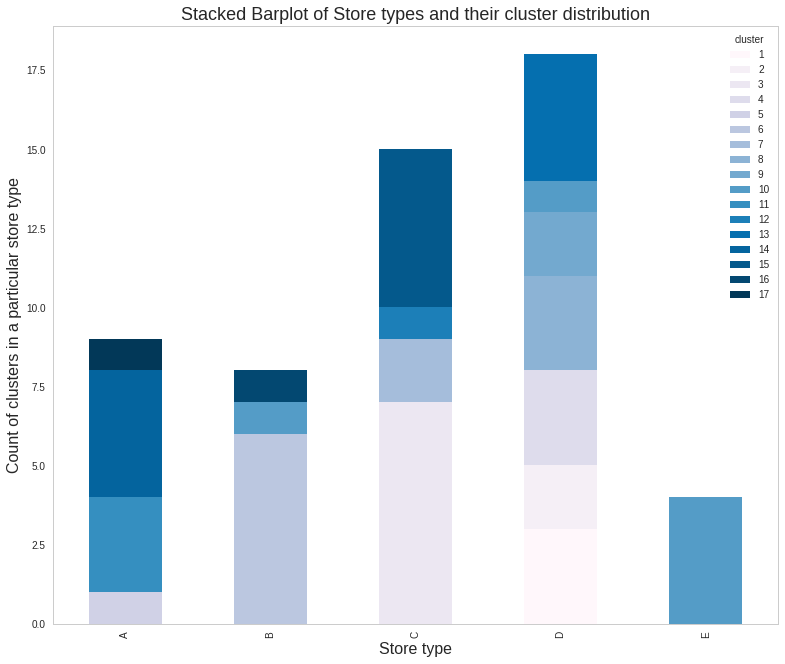

In [ ]:
plt.style.use('seaborn-whitegrid')
type_cluster = stores.groupby(['type','cluster']).size()
type_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'PuBu', figsize=(13,11),  grid=False)
plt.title('Stacked Barplot of Store types and their cluster distribution', fontsize=18)
plt.ylabel('Count of clusters in a particular store type', fontsize=16)
plt.xlabel('Store type', fontsize=16)
plt.show()

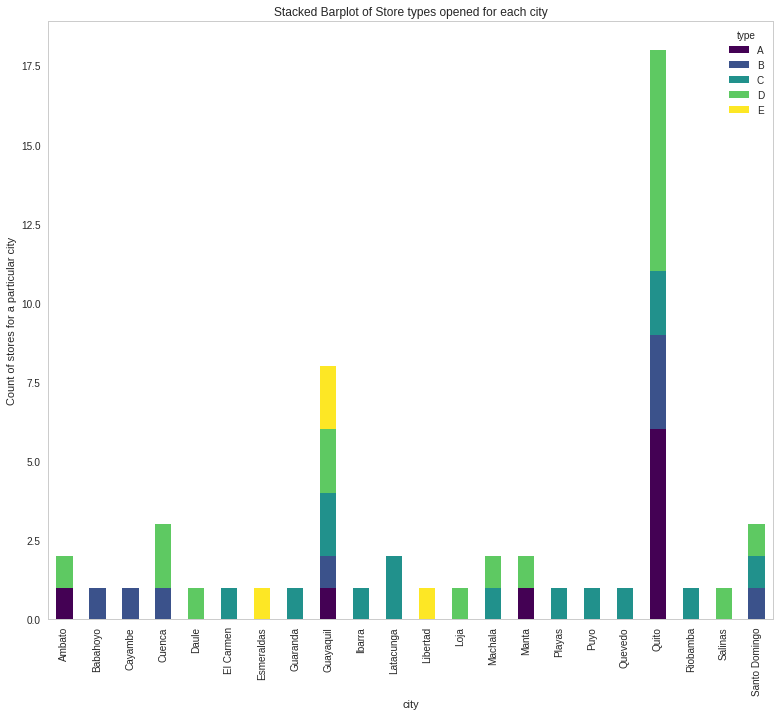

In [ ]:
plt.style.use('seaborn-whitegrid')
city_cluster = stores.groupby(['city','type']).store_nbr.size()
city_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'viridis', figsize=(13,11),  grid=False)
plt.title('Stacked Barplot of Store types opened for each city')
plt.ylabel('Count of stores for a particular city')
plt.show()

Guayaquil and Quito are two cities that stand out in terms of the range of retail kinds available. These are unsurprising given that Quito is Ecuador's capital and Guayaquil is the country's largest and most populated metropolis. As a result, one might expect Corporacion Favorita to target these major cities with the most diverse store types, as evidenced by the highest counts of store nbrs attributed to those two cities.

In [ ]:
store_transactions = pd.merge(transactions,stores, on="store_nbr")

In [ ]:
trans_type = store_transactions.groupby(['type'])["transactions"].sum().reset_index()

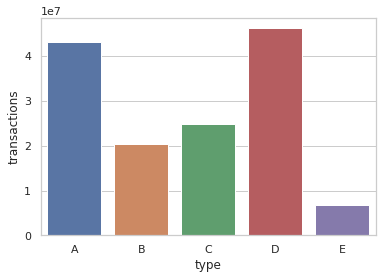

In [ ]:
sns.set(style="whitegrid")
sns.barplot(x="type", y="transactions", data=trans_type, capsize=.2)

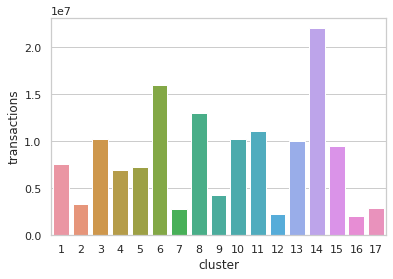

In [ ]:
trans_type = store_transactions.groupby(['cluster'])["transactions"].sum().reset_index()
sns.set(style="whitegrid")
sns.barplot(x="cluster", y="transactions", data=trans_type, capsize=.2)

In [ ]:
store_unit_sales = pd.merge(train_large[(train_large["date"]>=pd.datetime(2017,1,1)],store,left_on ="store_nbr",right_on ="Date")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [ ]:
store_unit_sales_dummy = pd.concat([store_unit_sales,pd.get_dummies(store_unit_sales['type'],"type"),pd.get_dummies(store_unit_sales['cluster'],"cluster")],axis=1)


In [ ]:
cols = list(store_unit_sales_dummy.iloc[:,10:].columns.values)
cols.append("unit_sales")

In [ ]:

store_unit_sales_dummy[cols].corr()

## Holiday Events Data

In [ ]:
holiday_events.head(3)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



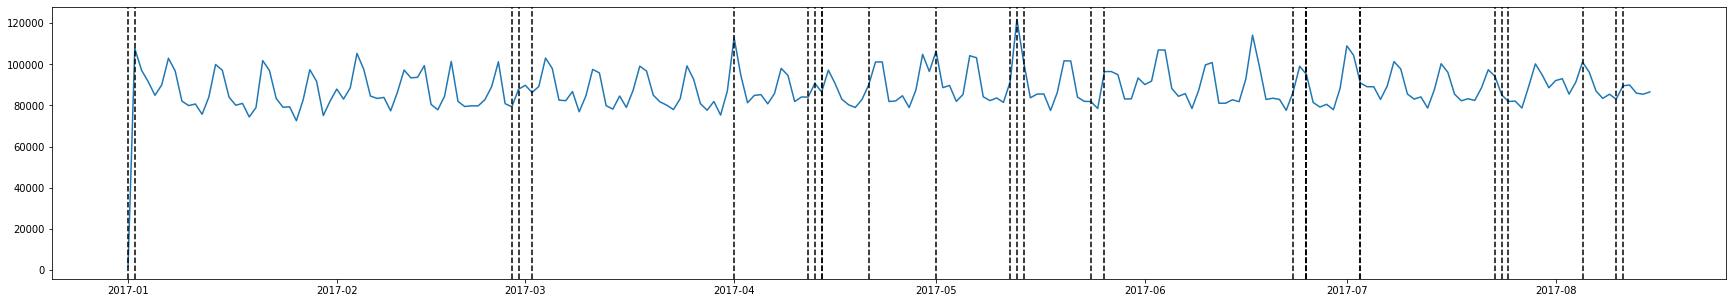

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(transactions[transactions["date"]>=pd.datetime(2017,1,1)].groupby("date")["transactions"].sum());
for xc in holiday_events[(holiday_events["date"]>=pd.datetime(2017,1,1)) & (holiday_events["date"]<transactions.date.max())].date.values:
    plt.axvline(x=xc, color='k', linestyle='--')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



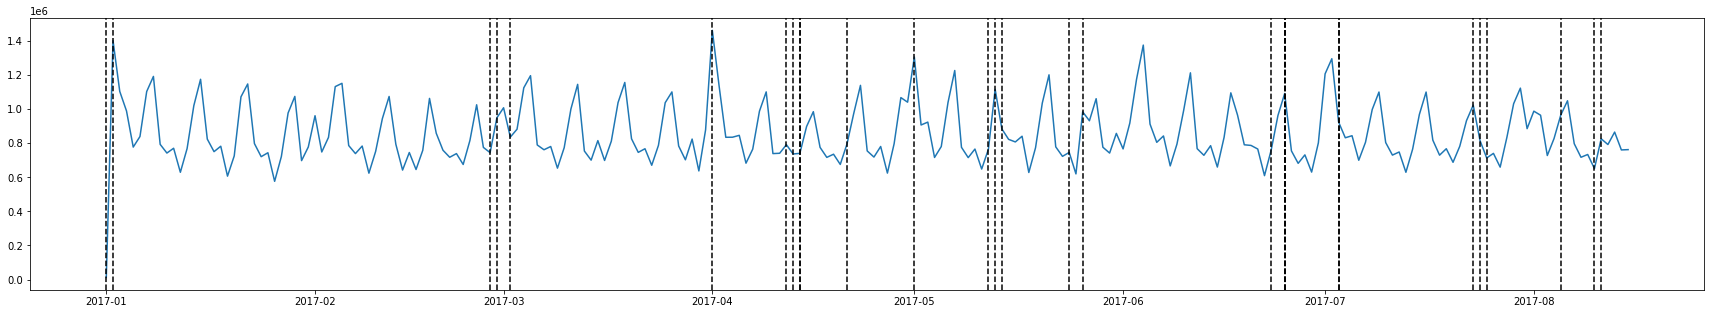

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(train_large[train_large["date"]>=pd.datetime(2017,1,1)].groupby("date")["unit_sales"].sum());
for xc in holiday_events[(holiday_events["date"]>=pd.datetime(2017,1,1)) & (holiday_events["date"]<train_large.date.max())].date.values:
    plt.axvline(x=xc, color='k', linestyle='--')

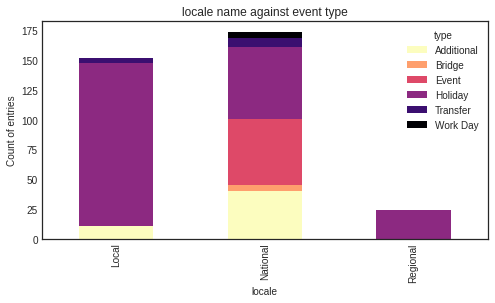

In [ ]:
plt.style.use('seaborn-white')
holiday_local_type = holiday_events.groupby(['locale', 'type']).size()
holiday_local_type.unstack().plot(kind='bar',stacked=True, colormap= 'magma_r', figsize=(8,4),  grid=False)
plt.title('locale name against event type')
plt.ylabel('Count of entries')
plt.show()

## Transactions data

In [ ]:
transactions.head(3)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358


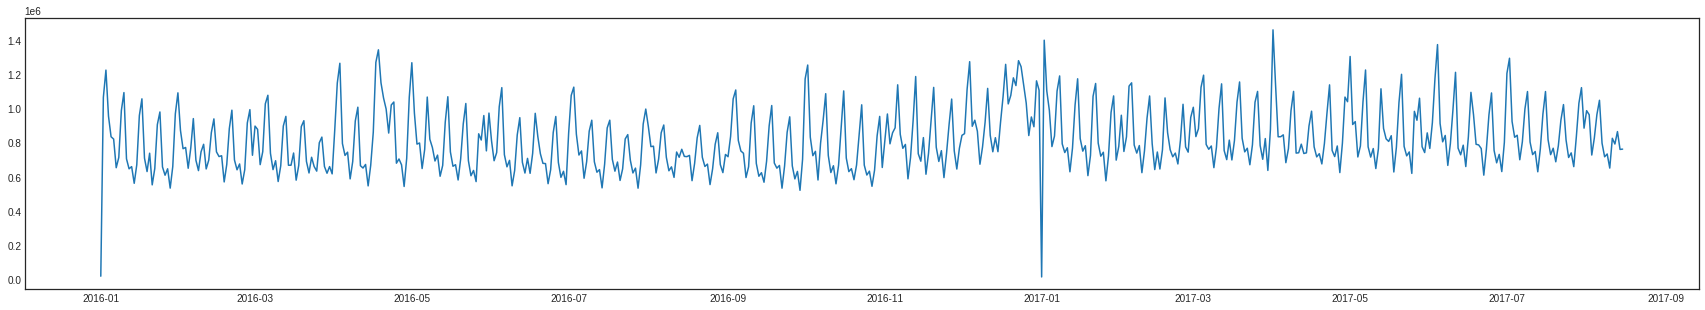

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(train_large.groupby("date")["unit_sales"].sum());

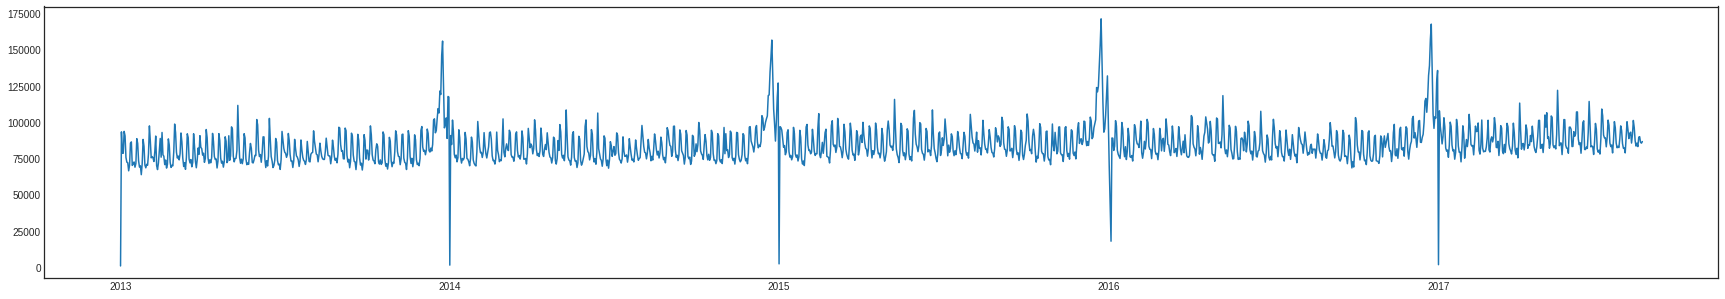

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(transactions.groupby("date")["transactions"].sum());

In [ ]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
dow = train_large.groupby(train_large['date'].dt.day_name())['unit_sales'].sum().reindex(days).reset_index()

In [ ]:
dow

,date,unit_sales
0,Monday,6.709030e+07
1,Tuesday,6.243618e+07
2,Wednesday,6.456669e+07
3,Thursday,5.407954e+07
4,Friday,6.413968e+07
5,Saturday,8.304635e+07
6,Sunday,8.749158e+07


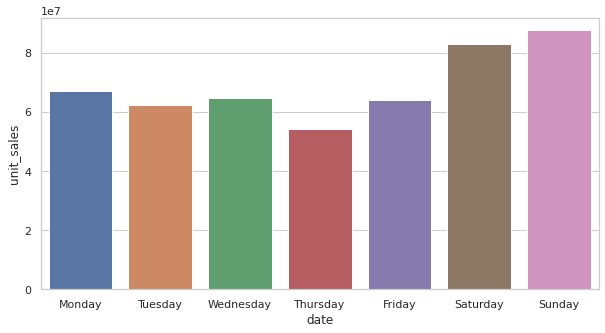

In [ ]:
plt.figure(figsize=(10,5))

# train_large.groupby(train_large['date'].dt.day_name())['unit_sales'].sum().reindex(days).plot.bar()
sns.set(style="whitegrid")
sns.barplot(x="date", y="unit_sales", data=dow, capsize=.2)



## Items data

In [ ]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [ ]:
items["class"].unique()

array([1093, 1067, 3008, 1028, 2712, 1045, 1034, 1044, 1092, 1032, 1030,
       1075, 2636, 2644, 3044, 1004, 2416, 2502, 1062, 3024, 1072, 1016,
       4126, 3034, 1014, 1040, 1084, 7034, 1056, 3090, 3026, 1042, 1122,
       6810, 2124, 3020, 2114, 1026, 2112, 1096, 2704, 2708, 1013, 3038,
       1048, 2116, 3032, 1124, 1066, 2718, 1236, 1080, 3004, 1058, 6824,
       1136, 3016, 1006, 2302, 1010, 2632, 2226, 2412, 1078, 1074, 1036,
       3046, 3022, 3018, 1035, 2104, 1086, 1039, 6155, 2806, 1120, 1002,
       2218, 2220, 1060, 2986, 2720, 3014, 6806, 4114, 1087, 3015, 2702,
       3006, 2752, 2652, 2630, 2640, 3010, 3012, 1024, 1038, 2716, 1076,
       2966, 1386, 2102, 7016, 2980, 2962, 3030, 1079, 1012, 2690, 1070,
       2662, 3005, 2142, 2960, 1054, 4122, 2850, 4222, 1033, 2306, 1336,
       2756, 1330, 2664, 4214, 2956, 3028, 1338, 2802, 4254, 2722, 1027,
       2642, 2854, 2222, 1005, 2228, 2238, 3060, 1318, 3040, 1320, 2214,
       6706, 2304, 1025, 2128, 6920, 2130, 1008, 30

In [ ]:
x, y = (list(x) for x in zip(*sorted(zip(items.family.value_counts().index, 
                                         items.family.value_counts().values), 
                                        reverse = False)))
trace2 = go.Bar(
    y=items.family.value_counts().values,
    x=items.family.value_counts().index,
    marker=dict(
        color=items.family.value_counts().values,
        colorscale = 'Portland',
        reversescale = False
    ),
    orientation='v',
)

layout = dict(
    title='Counts of items per family category',
     width = 800, height = 800,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
# py.iplot(fig1, filename='plots')
fig1.show(renderer="colab")

As we can see from the plot, the top 3 family categories are the GROCERY I, BEVERAGES and CLEANING categories.

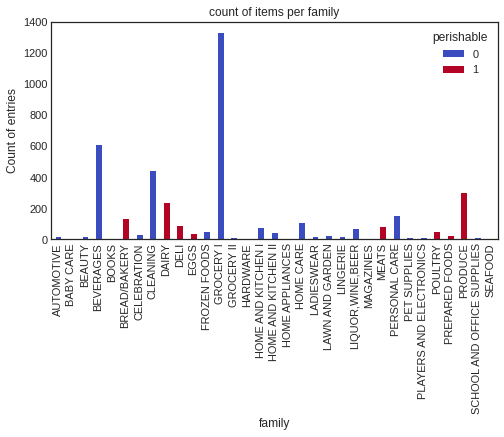

In [ ]:
plt.style.use('seaborn-white')
fam_perishable = items.groupby(['family', 'perishable']).size()
fam_perishable.unstack().plot(kind='bar',stacked=True, colormap= 'coolwarm', figsize=(8,4),  grid=False)
plt.title('count of items per family')
plt.ylabel('Count of entries')
plt.show()

## Target Analysis

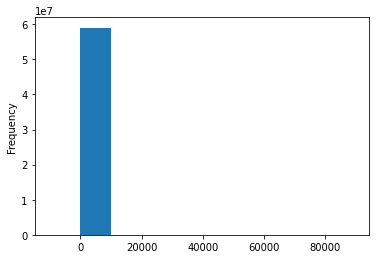

In [ ]:
train_large["unit_sales"].plot.hist()

In [ ]:
sns.distplot(train_large["unit_sales"])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



In [ ]:
train_large["log_unit_sales"] = train_large['unit_sales'].apply(lambda u: np.log1p(float(u)) if float(u) > 0 else 0)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



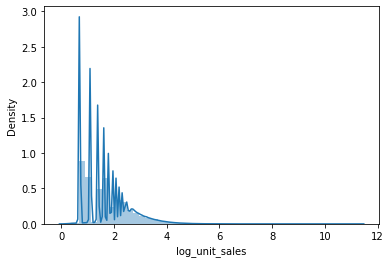

In [ ]:
sns.distplot(train_large["log_unit_sales"])